In [83]:
# Install required packages (if not already there)
!pip install pandas matplotlib textblob --quiet

# Import Python libraries
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      100 non-null    object
 1   productID       100 non-null    object
 2   rating          100 non-null    int64 
 3   reviewText      100 non-null    object
 4   unixReviewTime  100 non-null    int64 
 5   reviewTime      100 non-null    object
dtypes: int64(2), object(4)
memory usage: 4.8+ KB
Total reviews: 100
Unique products: 10
Unique users: 28


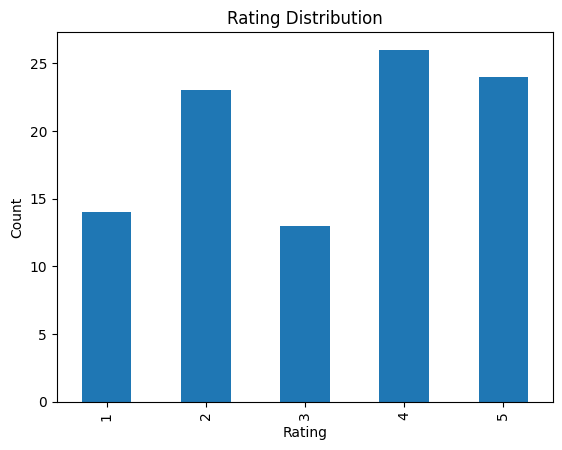

In [84]:
# Load the dataset
df = pd.read_csv("synthetic_amazon_reviews.csv")

# See first few rows
df.head()

# Check basic info
df.info()

# See how many reviews, products, users, etc.
print("Total reviews:", len(df))
print("Unique products:", df['productID'].nunique())
print("Unique users:", df['reviewerID'].nunique())

# Rating distribution
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()




In [85]:
# Handle missing values
df['reviewText'] = df['reviewText'].fillna('')

# Remove duplicates
df.drop_duplicates(inplace=True)

# Convert time
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')
df['reviewDate'] = df['unixReviewTime'].dt.date

print("Cleaned Data Ready")


Cleaned Data Ready 


In [86]:
# Calculate review text length (number of characters)
df['review_length'] = df['reviewText'].apply(len)

# Count words in each review
df['word_count'] = df['reviewText'].apply(lambda x: len(x.split()))

# Show the first few rows with new columns
df.head()


,reviewerID,productID,rating,reviewText,unixReviewTime,reviewTime,reviewDate,review_length,word_count
0,U021,P002,1,Love bad bad slow cheap quality great bad love.,2024-09-08,2024-09-08,2024-09-08,47,9
1,U001,P009,2,Fast perfect perfect hate recommend slow bad p...,2023-09-28,2023-09-28,2023-09-28,90,15
2,U026,P001,4,Bad terrible great hate quality recommend hate...,2025-06-06,2025-06-06,2025-06-06,87,13
3,U004,P007,3,Quality perfect perfect love love terrible fas...,2025-08-05,2025-08-05,2025-08-05,77,12
4,U021,P009,2,Hate slow great recommend slow perfect great t...,2023-05-23,2023-05-23,2023-05-23,97,15


In [87]:
df.head()


,reviewerID,productID,rating,reviewText,unixReviewTime,reviewTime,reviewDate,review_length,word_count
0,U021,P002,1,Love bad bad slow cheap quality great bad love.,2024-09-08,2024-09-08,2024-09-08,47,9
1,U001,P009,2,Fast perfect perfect hate recommend slow bad p...,2023-09-28,2023-09-28,2023-09-28,90,15
2,U026,P001,4,Bad terrible great hate quality recommend hate...,2025-06-06,2025-06-06,2025-06-06,87,13
3,U004,P007,3,Quality perfect perfect love love terrible fas...,2025-08-05,2025-08-05,2025-08-05,77,12
4,U021,P009,2,Hate slow great recommend slow perfect great t...,2023-05-23,2023-05-23,2023-05-23,97,15


In [88]:
# --- run this in one cell ---
# ensure reviewText is string
df['reviewText'] = df['reviewText'].fillna('').astype(str)

# text features
df['review_length'] = df['reviewText'].str.len()               # characters
df['word_count'] = df['reviewText'].str.split().str.len()      # words
df['num_exclamations'] = df['reviewText'].str.count('!')

# is a very short review? (helpful flag)
df['is_very_short'] = df['word_count'] <= 5

# user activity window: days between first and last review
user_dates = df.groupby('reviewerID')['unixReviewTime'].agg(['min','max']).reset_index()
user_dates['active_days'] = (pd.to_datetime(user_dates['max']) - pd.to_datetime(user_dates['min'])).dt.days

# Drop the existing active_days columns if they exist
df = df.drop(columns=[col for col in df.columns if 'active_days' in col])

df = df.merge(user_dates[['reviewerID','active_days']], on='reviewerID', how='left')

# reviews per user (already computed as total_reviews earlier). If not, compute now:
if 'total_reviews' not in df.columns:
    df['total_reviews'] = df.groupby('reviewerID')['rating'].transform('count')

# quick peek
df[['reviewerID','productID','rating','word_count','review_length','num_exclamations','total_reviews','active_days']].head()

,reviewerID,productID,rating,word_count,review_length,num_exclamations,total_reviews,active_days
0,U021,P002,1,9,47,0,8,649
1,U001,P009,2,15,90,0,3,741
2,U026,P001,4,13,87,0,4,585
3,U004,P007,3,12,77,0,8,526
4,U021,P009,2,15,97,0,8,649


In [89]:
# Reviews per day (approx)
df['reviews_per_day'] = df['total_reviews'] / (df['active_days'].replace(0,1))

# Flag highly active users (thresholds you can change)
# Example: >= 2 reviews per day on average and at least 5 reviews total
df['flag_user_bursty'] = (df['reviews_per_day'] >= 2) & (df['total_reviews'] >= 5)

# Show top flagged users
bursty_users = df[df['flag_user_bursty']].groupby('reviewerID').agg(
    total_reviews=('total_reviews','first'), reviews_per_day=('reviews_per_day','first')
).sort_values('reviews_per_day', ascending=False).reset_index()
bursty_users.head(20)

,reviewerID,total_reviews,reviews_per_day


In [90]:
# convert to datetime date if not yet
df['date'] = pd.to_datetime(df['unixReviewTime']).dt.date

# daily product counts
daily_prod = df.groupby(['productID','date']).size().reset_index(name='daily_count')

# compute 7-day rolling sum per product (need a time series per product)
daily_prod['date'] = pd.to_datetime(daily_prod['date'])
daily_prod = daily_prod.sort_values(['productID','date'])

# create 7-day rolling sum per product
daily_prod['rolling_7d'] = daily_prod.groupby('productID')['daily_count'].transform(lambda s: s.rolling(window=7, min_periods=1).sum())

# find product-days with high rolling_7d (example threshold: >= 10 reviews in 7 days)
spikes = daily_prod[daily_prod['rolling_7d'] >= 10].sort_values(['rolling_7d'], ascending=False)
spikes.head(20)


,productID,date,daily_count,rolling_7d


In [91]:
# flag promotional phrases simple list
promo_phrases = ['best product','highly recommend','five stars','works great','excellent product','buy now']
df['lower_text'] = df['reviewText'].str.lower()
df['has_promo_phrase'] = df['lower_text'].apply(lambda t: any(p in t for p in promo_phrases))

# flag many 5-star reviews by the user
df['user_pct_5star'] = df.groupby('reviewerID')['rating'].transform(lambda s: (s==5).mean())
df['flag_user_always_5'] = df['user_pct_5star'] >= 0.9  # user gives >=90% five-star ratings

# Example peek
df[['reviewerID','rating','word_count','has_promo_phrase','user_pct_5star','flag_user_always_5']].head(20)


,reviewerID,rating,word_count,has_promo_phrase,user_pct_5star,flag_user_always_5
0,U021,1,9,False,0.000000,False
1,U001,2,15,False,0.333333,False
2,U026,4,13,False,0.000000,False
3,U004,3,12,False,0.375000,False
4,U021,2,15,False,0.000000,False
5,U008,5,9,False,0.500000,False
6,U021,4,14,False,0.000000,False
7,U001,5,7,False,0.333333,False
8,U018,1,14,False,0.166667,False
9,U022,5,7,False,0.400000,False


In [92]:
def compute_score(row):
    score = 0
    # text-based
    if row['is_very_short']: score += 2
    if row['has_promo_phrase']: score += 2
    if row['num_exclamations'] >= 2: score += 1
    # user-based
    if row['flag_user_bursty']: score += 3
    if row['flag_user_always_5']: score += 2
    # product-based: if product had a 7-day spike containing this review date
    # We'll join rolling_7d into df for quick lookup (prepare below)
    return score

# join rolling_7d back into main df to use product spike info
daily_prod_small = daily_prod[['productID','date','rolling_7d']]
daily_lookup = daily_prod_small.copy()
daily_lookup['date'] = daily_lookup['date'].dt.date
df = df.merge(daily_lookup, left_on=['productID','date'], right_on=['productID','date'], how='left')
df['rolling_7d'] = df['rolling_7d'].fillna(0)

# add product-spike flag
df['flag_product_spike'] = df['rolling_7d'] >= 10

# now compute score and add product spike weight
df['base_score'] = df.apply(compute_score, axis=1)
df.loc[df['flag_product_spike'], 'base_score'] += 3

# create final suspicious score
df['suspicious_score'] = df['base_score']

# show top suspicious reviews
df.sort_values('suspicious_score', ascending=False)[['reviewerID','productID','rating','reviewText','suspicious_score']].head(30)


,reviewerID,productID,rating,reviewText,suspicious_score
24,U027,P004,2,Fast perfect hate great slow.,2
28,U010,P007,5,Hate love slow quality hate.,2
15,U017,P009,2,Terrible great love quality fast.,2
60,U027,P003,4,Bad terrible hate bad recommend.,2
73,U007,P010,1,Slow love bad quality great.,2
80,U019,P009,5,Fast perfect recommend terrible perfect terrib...,2
52,U028,P010,5,Terrible fast love great slow.,2
86,U013,P001,4,Cheap great hate perfect perfect.,2
3,U004,P007,3,Quality perfect perfect love love terrible fas...,0
2,U026,P001,4,Bad terrible great hate quality recommend hate...,0


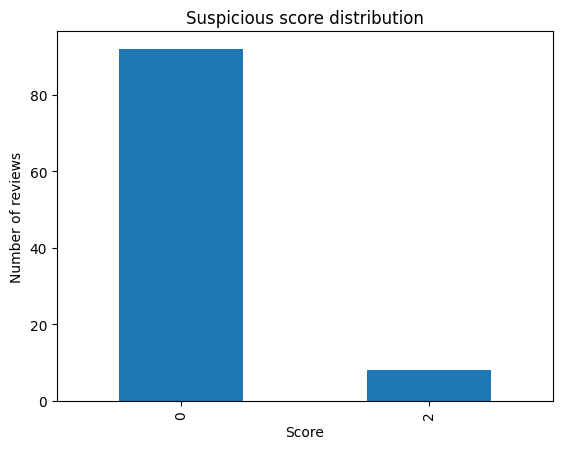

No product spikes found in this dataset with current thresholds.


In [93]:
# 1) distribution of suspicious scores
df['suspicious_score'].value_counts().sort_index().plot(kind='bar')
plt.title('Suspicious score distribution')
plt.xlabel('Score')
plt.ylabel('Number of reviews')
plt.show()

# 2) time series for a product with spikes (choose one product flagged in spikes)
if not spikes.empty:
    prod = spikes.iloc[0]['productID']
    prod_ts = df[df['productID']==prod].groupby('date').size().reset_index(name='count')
    prod_ts['date'] = pd.to_datetime(prod_ts['date'])
    plt.plot(prod_ts['date'], prod_ts['count'])
    plt.title(f"Daily reviews for product {prod}")
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.show()
else:
    print("No product spikes found in this dataset with current thresholds.")


In [94]:
# Top suspicious reviews (score >= threshold)
threshold = 4
flagged_reviews = df[df['suspicious_score'] >= threshold].sort_values('suspicious_score', ascending=False)
flagged_reviews[['reviewerID','productID','rating','reviewText','suspicious_score']].head(50)

# Top suspicious users by average suspicious_score (useful to block/quarantine)
user_scores = df.groupby('reviewerID')['suspicious_score'].mean().reset_index().sort_values('suspicious_score', ascending=False)
user_scores.head(30)


,reviewerID,suspicious_score
17,U019,2.000000
5,U007,0.666667
25,U027,0.666667
8,U010,0.500000
15,U017,0.500000
26,U028,0.500000
11,U013,0.500000
4,U006,0.000000
3,U005,0.000000
2,U004,0.000000


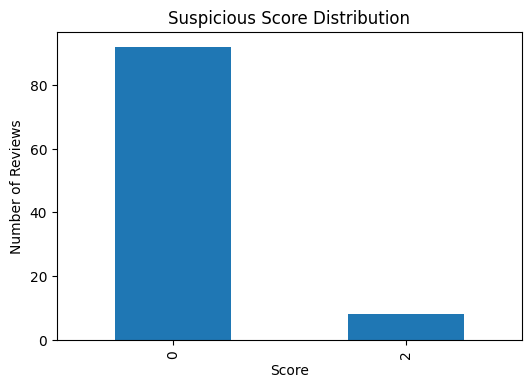

No product spikes detected with current settings.

Top suspicious reviews (score >= 4):
Empty DataFrame
Columns: [reviewerID, productID, rating, reviewText, suspicious_score]
Index: []

Top suspicious users:
   reviewerID  suspicious_score
17       U019          2.000000
5        U007          0.666667
25       U027          0.666667
8        U010          0.500000
15       U017          0.500000
26       U028          0.500000
11       U013          0.500000
4        U006          0.000000
3        U005          0.000000
2        U004          0.000000
1        U003          0.000000
0        U001          0.000000
10       U012          0.000000
9        U011          0.000000
6        U008          0.000000

✅ Analysis complete!


In [95]:
# ============================================================
# FAKE REVIEW DETECTION (BEGINNER-FRIENDLY)
# ============================================================

# STEP 0 - Install libraries
!pip install pandas matplotlib textblob --quiet

# STEP 1 - Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob

# STEP 2 - Load dataset (make sure you uploaded small_amazon_reviews.csv in Colab)
df = pd.read_csv("synthetic_amazon_reviews.csv")

# --- BASIC CLEANING ---
df['reviewText'] = df['reviewText'].fillna('').astype(str)
df.drop_duplicates(inplace=True)

# convert timestamp to datetime
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')
# Convert 'date' column to datetime objects before merging
df['date'] = pd.to_datetime(df['unixReviewTime'].dt.date)

# ============================================================
# STEP 3 - FEATURE ENGINEERING
# ============================================================
df['review_length'] = df['reviewText'].str.len()
df['word_count'] = df['reviewText'].str.split().str.len()
df['num_exclamations'] = df['reviewText'].str.count('!')
df['is_very_short'] = df['word_count'] <= 5

# total reviews per user
user_review_counts = df['reviewerID'].value_counts().reset_index()
user_review_counts.columns = ['reviewerID', 'total_reviews']
df = df.merge(user_review_counts, on='reviewerID', how='left')

# average rating per user
user_avg_rating = df.groupby('reviewerID')['rating'].mean().reset_index()
user_avg_rating.columns = ['reviewerID', 'avg_user_rating']
df = df.merge(user_avg_rating, on='reviewerID', how='left')

# user active days
user_dates = df.groupby('reviewerID')['unixReviewTime'].agg(['min','max']).reset_index()
user_dates['active_days'] = (pd.to_datetime(user_dates['max']) - pd.to_datetime(user_dates['min'])).dt.days
df = df.merge(user_dates[['reviewerID','active_days']], on='reviewerID', how='left')
df['reviews_per_day'] = df['total_reviews'] / (df['active_days'].replace(0,1))

# flag bursty users (>=2 reviews/day & >=5 total)
df['flag_user_bursty'] = (df['reviews_per_day'] >= 2) & (df['total_reviews'] >= 5)

# ============================================================
# STEP 4 - PRODUCT SPIKES
# ============================================================
daily_prod = df.groupby(['productID','date']).size().reset_index(name='daily_count')
daily_prod['date'] = pd.to_datetime(daily_prod['date'])
daily_prod = daily_prod.sort_values(['productID','date'])
daily_prod['rolling_7d'] = daily_prod.groupby('productID')['daily_count'].transform(lambda s: s.rolling(window=7, min_periods=1).sum())
spikes = daily_prod[daily_prod['rolling_7d'] >= 10]
df = df.merge(daily_prod[['productID','date','rolling_7d']], on=['productID','date'], how='left')
df['rolling_7d'] = df['rolling_7d'].fillna(0)
df['flag_product_spike'] = df['rolling_7d'] >= 10

# ============================================================
# STEP 5 - TEXT FLAGS
# ============================================================
promo_phrases = ['best product','highly recommend','five stars','works great','excellent product','buy now']
df['lower_text'] = df['reviewText'].str.lower()
df['has_promo_phrase'] = df['lower_text'].apply(lambda t: any(p in t for p in promo_phrases))
df['user_pct_5star'] = df.groupby('reviewerID')['rating'].transform(lambda s: (s==5).mean())
df['flag_user_always_5'] = df['user_pct_5star'] >= 0.9

# ============================================================
# STEP 6 - RULE-BASED SCORE
# ============================================================
def compute_score(row):
    score = 0
    if row['is_very_short']: score += 2
    if row['has_promo_phrase']: score += 2
    if row['num_exclamations'] >= 2: score += 1
    if row['flag_user_bursty']: score += 3
    if row['flag_user_always_5']: score += 2
    if row['flag_product_spike']: score += 3
    return score

df['suspicious_score'] = df.apply(compute_score, axis=1)

# ============================================================
# STEP 7 - VISUALIZATIONS
# ============================================================
plt.figure(figsize=(6,4))
df['suspicious_score'].value_counts().sort_index().plot(kind='bar')
plt.title('Suspicious Score Distribution')
plt.xlabel('Score')
plt.ylabel('Number of Reviews')
plt.show()

# show one product's daily review pattern (if spike exists)
if not spikes.empty:
    prod = spikes.iloc[0]['productID']
    prod_ts = df[df['productID']==prod].groupby('date').size().reset_index(name='count')
    prod_ts['date'] = pd.to_datetime(prod_ts['date'])
    plt.plot(prod_ts['date'], prod_ts['count'])
    plt.title(f"Daily Reviews for Product {prod}")
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.show()
else:
    print("No product spikes detected with current settings.")

# ============================================================
# STEP 8 - RESULTS
# ============================================================
print("\nTop suspicious reviews (score >= 4):")
flagged_reviews = df[df['suspicious_score'] >= 4].sort_values('suspicious_score', ascending=False)
print(flagged_reviews[['reviewerID','productID','rating','reviewText','suspicious_score']].head(15))

print("\nTop suspicious users:")
user_scores = df.groupby('reviewerID')['suspicious_score'].mean().reset_index().sort_values('suspicious_score', ascending=False)
print(user_scores.head(15))

print("\n✅ Analysis complete!")

,reviewerID,productID,rating,reviewText,unixReviewTime,reviewTime
0,U021,P002,1,Love bad bad slow cheap quality great bad love.,1725753600,2024-09-08
1,U001,P009,2,Fast perfect perfect hate recommend slow bad p...,1695859200,2023-09-28
2,U026,P001,4,Bad terrible great hate quality recommend hate...,1749168000,2025-06-06
3,U004,P007,3,Quality perfect perfect love love terrible fas...,1754352000,2025-08-05
4,U021,P009,2,Hate slow great recommend slow perfect great t...,1684800000,2023-05-23


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      100 non-null    object
 1   productID       100 non-null    object
 2   rating          100 non-null    int64 
 3   reviewText      100 non-null    object
 4   unixReviewTime  100 non-null    int64 
 5   reviewTime      100 non-null    object
dtypes: int64(2), object(4)
memory usage: 4.8+ KB
Total reviews: 100
Unique products: 10
Unique users: 28


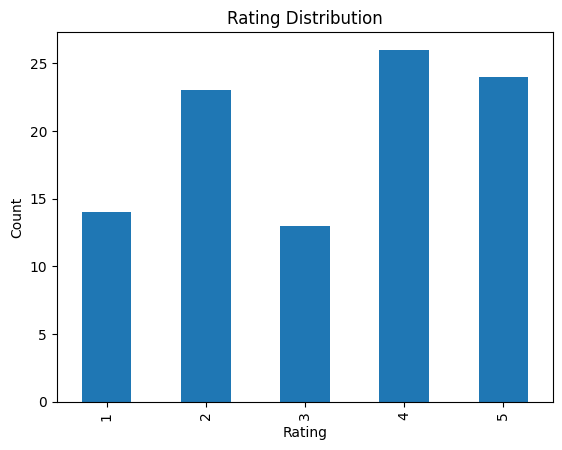

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

# 🟢 replace the path inside read_csv with your copied path
df = pd.read_csv("/content/synthetic_amazon_reviews.csv")

# Show first few rows to confirm load
display(df.head())

# Basic info about columns
df.info()

# Summary stats
print("Total reviews:", len(df))
print("Unique products:", df['productID'].nunique())
print("Unique users:", df['reviewerID'].nunique())

# Rating distribution
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [102]:
# 1️⃣ Count how many reviews each product gets per day
daily = df.groupby(['productID', 'reviewDate']).size().reset_index(name='daily_count')

# 2️⃣ Sort by product and date so we can check recent activity
daily['reviewDate'] = pd.to_datetime(daily['reviewDate'])
daily = daily.sort_values(['productID', 'reviewDate'])

# 3️⃣ Compute a 7-day rolling window for each product
daily['rolling_7d'] = daily.groupby('productID')['daily_count'].transform(
    lambda s: s.rolling(7, min_periods=1).sum()
)

# 4️⃣ Drop existing rolling_7d columns before merging to avoid conflicts
df = df.drop(columns=[col for col in df.columns if 'rolling_7d' in col])

# 5️⃣ Merge this info back into main dataframe
daily2 = daily[['productID','reviewDate','rolling_7d']].copy()
# daily2['reviewDate'] = daily2['reviewDate'].dt.date # Removed .dt.date conversion
df = df.merge(daily2, on=['productID','reviewDate'], how='left')

# 6️⃣ Flag if the product had ≥10 reviews in any 7-day period
df['rolling_7d'] = df['rolling_7d'].fillna(0)
df['flag_product_spike'] = df['rolling_7d'] >= 10  # adjust threshold if dataset is small

# 7️⃣ Create a function that adds up all suspicious signals
def score_row(r):
    score = 0
    # review-level clues
    if r['is_very_short']: score += 2
    if r['has_promo_phrase']: score += 2
    if r['num_exclamations'] >= 2: score += 1
    # user-level clues
    if r['flag_user_bursty']: score += 3
    if r['flag_user_always_5']: score += 2
    # product-level clue
    if r['flag_product_spike']: score += 3
    return score

# 8️⃣ Apply the scoring function to every review
df['suspicious_score'] = df.apply(score_row, axis=1)

# 9️⃣ See the top 15 most suspicious reviews
display(
    df.sort_values('suspicious_score', ascending=False)[
        ['reviewerID','productID','rating','reviewText','suspicious_score']
    ].head(15)
)

,reviewerID,productID,rating,reviewText,suspicious_score
24,U027,P004,2,Fast perfect hate great slow.,2
28,U010,P007,5,Hate love slow quality hate.,2
15,U017,P009,2,Terrible great love quality fast.,2
60,U027,P003,4,Bad terrible hate bad recommend.,2
73,U007,P010,1,Slow love bad quality great.,2
80,U019,P009,5,Fast perfect recommend terrible perfect terrib...,2
52,U028,P010,5,Terrible fast love great slow.,2
86,U013,P001,4,Cheap great hate perfect perfect.,2
3,U004,P007,3,Quality perfect perfect love love terrible fas...,0
2,U026,P001,4,Bad terrible great hate quality recommend hate...,0


In [101]:
# Combine necessary steps from previous cells to ensure df and required columns are available

# Load the dataset
df = pd.read_csv("/content/synthetic_amazon_reviews.csv")

# Basic cleaning
df['reviewText'] = df['reviewText'].fillna('').astype(str)
df.drop_duplicates(inplace=True)

# Convert unixReviewTime to datetime and extract date
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')
df['reviewDate'] = pd.to_datetime(df['unixReviewTime'].dt.date) # Ensure reviewDate is datetime object

# Basic text-based features
df['review_length'] = df['reviewText'].str.len()          # number of characters
df['word_count'] = df['reviewText'].str.split().str.len() # number of words
df['num_exclamations'] = df['reviewText'].str.count('!')  # count exclamation marks
df['is_very_short'] = df['word_count'] <= 5

# User-based features
df['total_reviews'] = df.groupby('reviewerID')['rating'].transform('count')
user_dates = df.groupby('reviewerID')['unixReviewTime'].agg(['min', 'max']).reset_index()
user_dates['active_days'] = (pd.to_datetime(user_dates['max']) - pd.to_datetime(user_dates['min'])).dt.days
df = df.merge(user_dates[['reviewerID', 'active_days']], on='reviewerID', how='left')
df['reviews_per_day'] = df['total_reviews'] / (df['active_days'].replace(0,1))
df['flag_user_bursty'] = (df['reviews_per_day'] >= 2) & (df['total_reviews'] >= 5)
df['user_pct_5star'] = df.groupby('reviewerID')['rating'].transform(lambda s: (s==5).mean())
df['flag_user_always_5'] = df['user_pct_5star'] >= 0.9


# Product-based features (Spikes)
daily = df.groupby(['productID', 'reviewDate']).size().reset_index(name='daily_count')
daily['reviewDate'] = pd.to_datetime(daily['reviewDate'])
daily = daily.sort_values(['productID', 'reviewDate'])
daily['rolling_7d'] = daily.groupby('productID')['daily_count'].transform(
    lambda s: s.rolling(7, min_periods=1).sum()
)
daily2 = daily[['productID','reviewDate','rolling_7d']].copy()
# No need to convert to .dt.date here as reviewDate is already datetime
df = df.merge(daily2, on=['productID','reviewDate'], how='left')
df['rolling_7d'] = df['rolling_7d'].fillna(0)
df['flag_product_spike'] = df['rolling_7d'] >= 10


# Text-based features (Promo phrases)
promo_phrases = ['best product','highly recommend','five stars','works great','excellent product','buy now']
df['lower_text'] = df['reviewText'].str.lower()
df['has_promo_phrase'] = df['lower_text'].apply(lambda t: any(p in t for p in promo_phrases))


# Create a function that adds up all suspicious signals
def score_row(r):
    score = 0
    # review-level clues
    if r['is_very_short']: score += 2
    if r['has_promo_phrase']: score += 2
    if r['num_exclamations'] >= 2: score += 1
    # user-level clues
    if r['flag_user_bursty']: score += 3
    if r['flag_user_always_5']: score += 2
    # product-level clue
    if r['flag_product_spike']: score += 3
    return score

# Apply the scoring function to every review
df['suspicious_score'] = df.apply(score_row, axis=1)

# See the top 15 most suspicious reviews
display(
    df.sort_values('suspicious_score', ascending=False)[
        ['reviewerID','productID','rating','reviewText','suspicious_score']
    ].head(15)
)

,reviewerID,productID,rating,reviewText,suspicious_score
24,U027,P004,2,Fast perfect hate great slow.,2
28,U010,P007,5,Hate love slow quality hate.,2
15,U017,P009,2,Terrible great love quality fast.,2
60,U027,P003,4,Bad terrible hate bad recommend.,2
73,U007,P010,1,Slow love bad quality great.,2
80,U019,P009,5,Fast perfect recommend terrible perfect terrib...,2
52,U028,P010,5,Terrible fast love great slow.,2
86,U013,P001,4,Cheap great hate perfect perfect.,2
3,U004,P007,3,Quality perfect perfect love love terrible fas...,0
2,U026,P001,4,Bad terrible great hate quality recommend hate...,0


In [104]:
# 1️⃣ Count how many reviews each product gets per day
daily = df.groupby(['productID', 'reviewDate']).size().reset_index(name='daily_count')

# 2️⃣ Sort by product and date so we can check recent activity
daily['reviewDate'] = pd.to_datetime(daily['reviewDate'])
daily = daily.sort_values(['productID', 'reviewDate'])

# 3️⃣ Compute a 7-day rolling window for each product
daily['rolling_7d'] = daily.groupby('productID')['daily_count'].transform(
    lambda s: s.rolling(7, min_periods=1).sum()
)

# 4️⃣ Convert df['reviewDate'] to datetime before merging
df['reviewDate'] = pd.to_datetime(df['reviewDate'])

# 5️⃣ Merge this info back into main dataframe
daily2 = daily[['productID','reviewDate','rolling_7d']].copy()
# Remove the .dt.date conversion here to keep reviewDate as datetime
# daily2['reviewDate'] = daily2['reviewDate'].dt.date # This line is now commented out in the previous modification

df = df.merge(daily2, on=['productID','reviewDate'], how='left')

# 6️⃣ Flag if the product had ≥10 reviews in any 7-day period
df['rolling_7d'] = df['rolling_7d'].fillna(0)
df['flag_product_spike'] = df['rolling_7d'] >= 10  # adjust threshold if dataset is small

# 7️⃣ Create a function that adds up all suspicious signals
def score_row(r):
    score = 0
    # review-level clues
    if r['is_very_short']: score += 2
    if r['has_promo_phrase']: score += 2
    if r['num_exclamations'] >= 2: score += 1
    # user-level clues
    if r['flag_user_bursty']: score += 3
    if r['flag_user_always_5']: score += 2
    # product-level clue
    if r['flag_product_spike']: score += 3
    return score

# 8️⃣ Apply the scoring function to every review
df['suspicious_score'] = df.apply(score_row, axis=1)

# 9️⃣ See the top 15 most suspicious reviews
display(
    df.sort_values('suspicious_score', ascending=False)[
        ['reviewerID','productID','rating','reviewText','suspicious_score']
    ].head(15)
)

,reviewerID,productID,rating,reviewText,suspicious_score
24,U027,P004,2,Fast perfect hate great slow.,2
28,U010,P007,5,Hate love slow quality hate.,2
15,U017,P009,2,Terrible great love quality fast.,2
60,U027,P003,4,Bad terrible hate bad recommend.,2
73,U007,P010,1,Slow love bad quality great.,2
80,U019,P009,5,Fast perfect recommend terrible perfect terrib...,2
52,U028,P010,5,Terrible fast love great slow.,2
86,U013,P001,4,Cheap great hate perfect perfect.,2
3,U004,P007,3,Quality perfect perfect love love terrible fas...,0
2,U026,P001,4,Bad terrible great hate quality recommend hate...,0


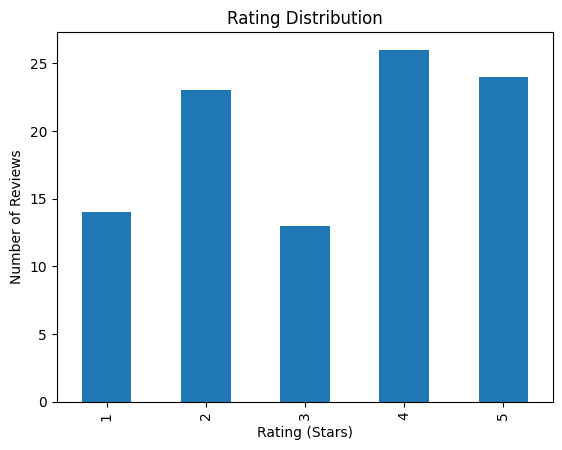

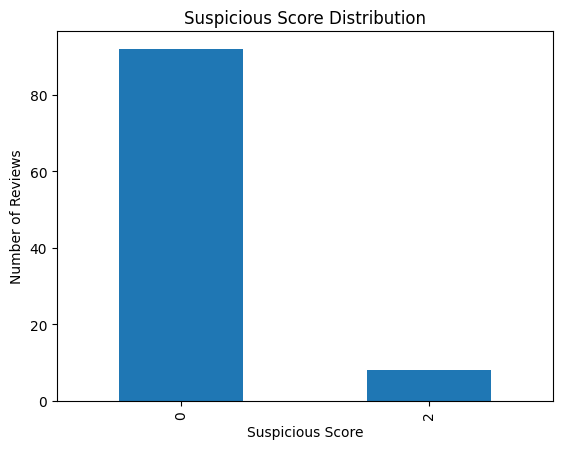

In [105]:
# 1️⃣ Rating Distribution
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating (Stars)')
plt.ylabel('Number of Reviews')
plt.show()

# 2️⃣ Suspicious Score Distribution
df['suspicious_score'].value_counts().sort_index().plot(kind='bar')
plt.title('Suspicious Score Distribution')
plt.xlabel('Suspicious Score')
plt.ylabel('Number of Reviews')
plt.show()

In [106]:
threshold = 4  # choose what "suspicious" means
flagged_reviews = df[df['suspicious_score'] >= threshold]
print("Total flagged reviews:", len(flagged_reviews))
display(flagged_reviews[['reviewerID','productID','rating','reviewText','suspicious_score']].head(20))

# Top suspicious users
user_scores = df.groupby('reviewerID')['suspicious_score'].mean().reset_index().sort_values('suspicious_score', ascending=False)
display(user_scores.head(10))

Total flagged reviews: 0


,reviewerID,productID,rating,reviewText,suspicious_score


,reviewerID,suspicious_score
17,U019,2.000000
5,U007,0.666667
25,U027,0.666667
8,U010,0.500000
15,U017,0.500000
26,U028,0.500000
11,U013,0.500000
4,U006,0.000000
3,U005,0.000000
2,U004,0.000000
